# Out-of-distribution

## Setup

### Config

In [30]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
from sklearn.decomposition import PCA
import seaborn as sns

CSV_PATH = "/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv"
IMAGE_DIR = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
MODEL_PATH = "/kaggle/input/augmented/pytorch/default/1/augmented_model.pt"

### Map CSV data

In [31]:
class CSVDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.image_col = 'image'
        self.class_cols = [col for col in self.df.columns if col != self.image_col]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = f"{self.df.iloc[idx][self.image_col]}.jpg"
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        row = self.df.iloc[idx][self.class_cols]
        label_idx = row.values.argmax()
        class_name = self.class_cols[label_idx]

        return image, class_name, img_name


### Helper functions

In [32]:
def entropy(p):
    return -torch.sum(p * torch.log(p + 1e-10), dim=1)

def get_confidence_by_true_class(model, loader, class_names):
    model.eval()
    confidence_dict = {cls: [] for cls in class_names}
    all_rows = []

    with torch.no_grad():
        for images, true_classes, filenames in tqdm(loader):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            for i in range(len(images)):
                row = {
                    "filename": filenames[i],
                    "true_class": true_classes[i],
                    "predicted_class": preds[i].item(),
                    "confidence": conf[i].item(),
                }
                confidence_dict[true_classes[i]].append(conf[i].item())
                all_rows.append(row)

    return confidence_dict, all_rows

## Research

### Load data

In [33]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = CSVDataset(CSV_PATH, IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.class_cols

### Load model

In [34]:
def load_model(path):
    model = torch.load(path, map_location=device)
    model.to(device)
    model.eval()
    return model
model = load_model(MODEL_PATH)

/tmp/ipykernel_31/1307709847.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path, map_location=device)


### Run

In [35]:
confidences, result_rows = get_confidence_by_true_class(model, dataloader, class_names)

100%|██████████| 792/792 [05:52<00:00,  2.25it/s]


### Results

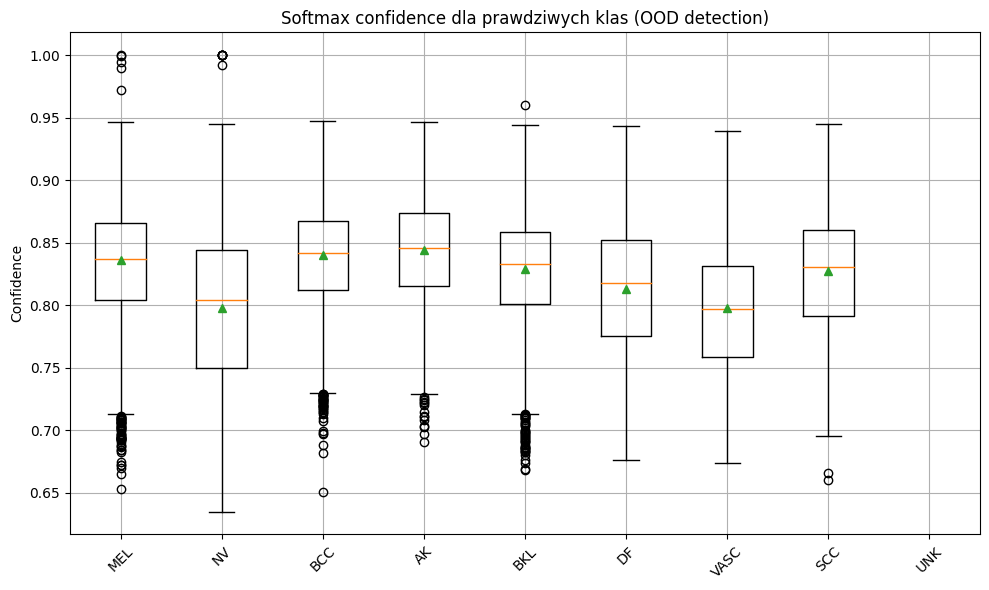

In [36]:
plt.figure(figsize=(10, 6))
plt.boxplot([confidences[cls] for cls in class_names], labels=class_names, showmeans=True)
plt.title("Softmax confidence dla prawdziwych klas (OOD detection)")
plt.ylabel("Confidence")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### PCA

100%|██████████| 792/792 [05:47<00:00,  2.28it/s]


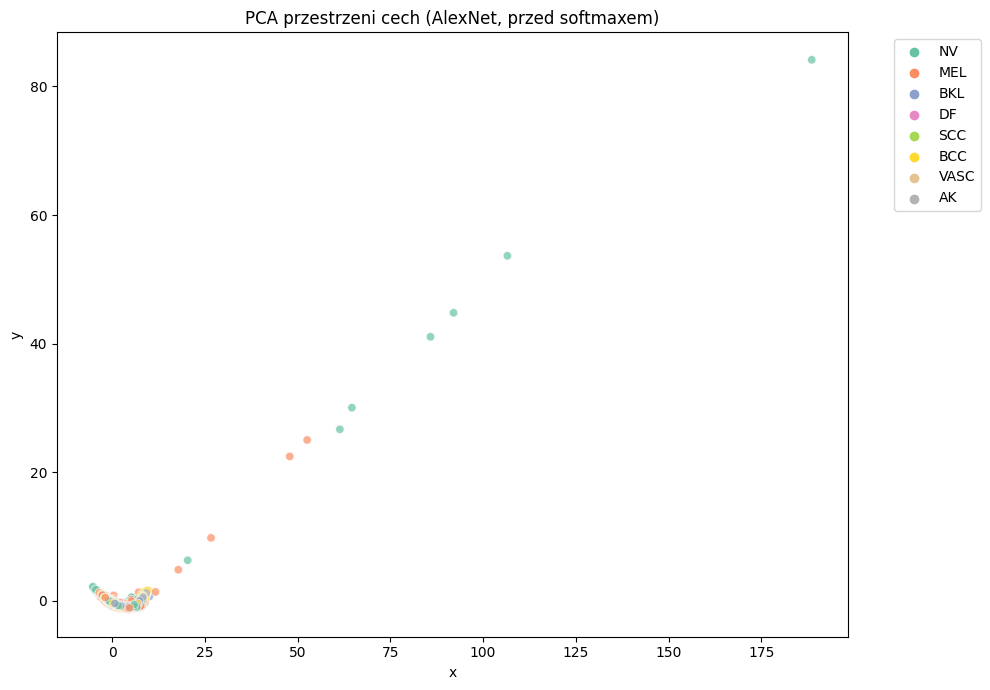

In [37]:
def extract_features(model, loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, true_classes, _ in tqdm(loader):
            images = images.to(device)

            x = model.features(images)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)
            x = model.classifier[:-1](x)
            
            features.append(x.cpu().numpy())
            labels.extend(true_classes)

    features = np.concatenate(features, axis=0)
    return features, labels

features, labels = extract_features(model, dataloader)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

plt.figure(figsize=(10, 7))
df_plot = pd.DataFrame({
    'x': features_2d[:, 0],
    'y': features_2d[:, 1],
    'label': labels
})

sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette='Set2', alpha=0.7)
plt.title("PCA przestrzeni cech (AlexNet, przed softmaxem)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()